In [1]:
!pip install mlxtend

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from collections import Counter
from mlxtend.frequent_patterns import fpgrowth, association_rules
import warnings
warnings.filterwarnings('ignore')

# memuat dataset
data = pd.read_csv('nike_sales_2024.csv')
data.head()

,Month,Region,Main_Category,Sub_Category,Product_Line,Price_Tier,Units_Sold,Revenue_USD,Online_Sales_Percentage,Retail_Price
0,November,India,Equipment,Bags,Gym Sack,Budget,48356,14506800,73,300
1,January,India,Equipment,Accessories,Hats,Budget,9842,2066820,50,210
2,October,India,Apparel,Tops,Tech Fleece,Mid-Range,25079,1755530,90,70
3,December,Greater China,Footwear,Cricket,Vapor Cricket,Premium,41404,8694840,58,210
4,May,Greater China,Equipment,Socks,Performance Socks,Premium,33569,5371040,53,160


In [3]:
data.tail()

,Month,Region,Main_Category,Sub_Category,Product_Line,Price_Tier,Units_Sold,Revenue_USD,Online_Sales_Percentage,Retail_Price
995,October,India,Equipment,Accessories,Hats,Mid-Range,9870,987000,82,100
996,July,Europe,Equipment,Socks,Performance Socks,Mid-Range,14668,2640240,88,180
997,August,Japan,Footwear,Football,Phantom Vision,Premium,15078,2261700,74,150
998,May,South Korea,Equipment,Socks,Crew Socks,Premium,26242,1312100,52,50
999,December,Japan,Footwear,Cricket,Vapor Cricket,Mid-Range,18133,5077240,68,280


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Month                    1000 non-null   object
 1   Region                   1000 non-null   object
 2   Main_Category            1000 non-null   object
 3   Sub_Category             1000 non-null   object
 4   Product_Line             1000 non-null   object
 5   Price_Tier               1000 non-null   object
 6   Units_Sold               1000 non-null   int64 
 7   Revenue_USD              1000 non-null   int64 
 8   Online_Sales_Percentage  1000 non-null   int64 
 9   Retail_Price             1000 non-null   int64 
dtypes: int64(4), object(6)
memory usage: 78.3+ KB


#PRE PROCESSING

In [5]:
# ===========================
# Preprocessing
# ===========================

#menghitung frekuensi produk yang sering dibeli
product_counts = data['Product_Line'].value_counts()

# Mendapatkan daftar produk unik
unique_items = data['Product_Line'].unique()

month_order = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]

#menggabungkan penjualan berdasarkan daerah dan bulan untuk membuat pola yang akan digunakan di EDA
sales_by_region_month = data.groupby(['Region', 'Month'])['Units_Sold'].sum().unstack()
#membuat daftar(list) transaksi
transaction_list = data.groupby(['Region', 'Month'])['Product_Line'].apply(list)

#membuat distribusi jumlah item per transaksi
data['Items_Per_Transaction'] = data.groupby(['Region', 'Month'])['Product_Line'].transform('count')

# EXPLORATORY DATA ANALYSIS (EDA)

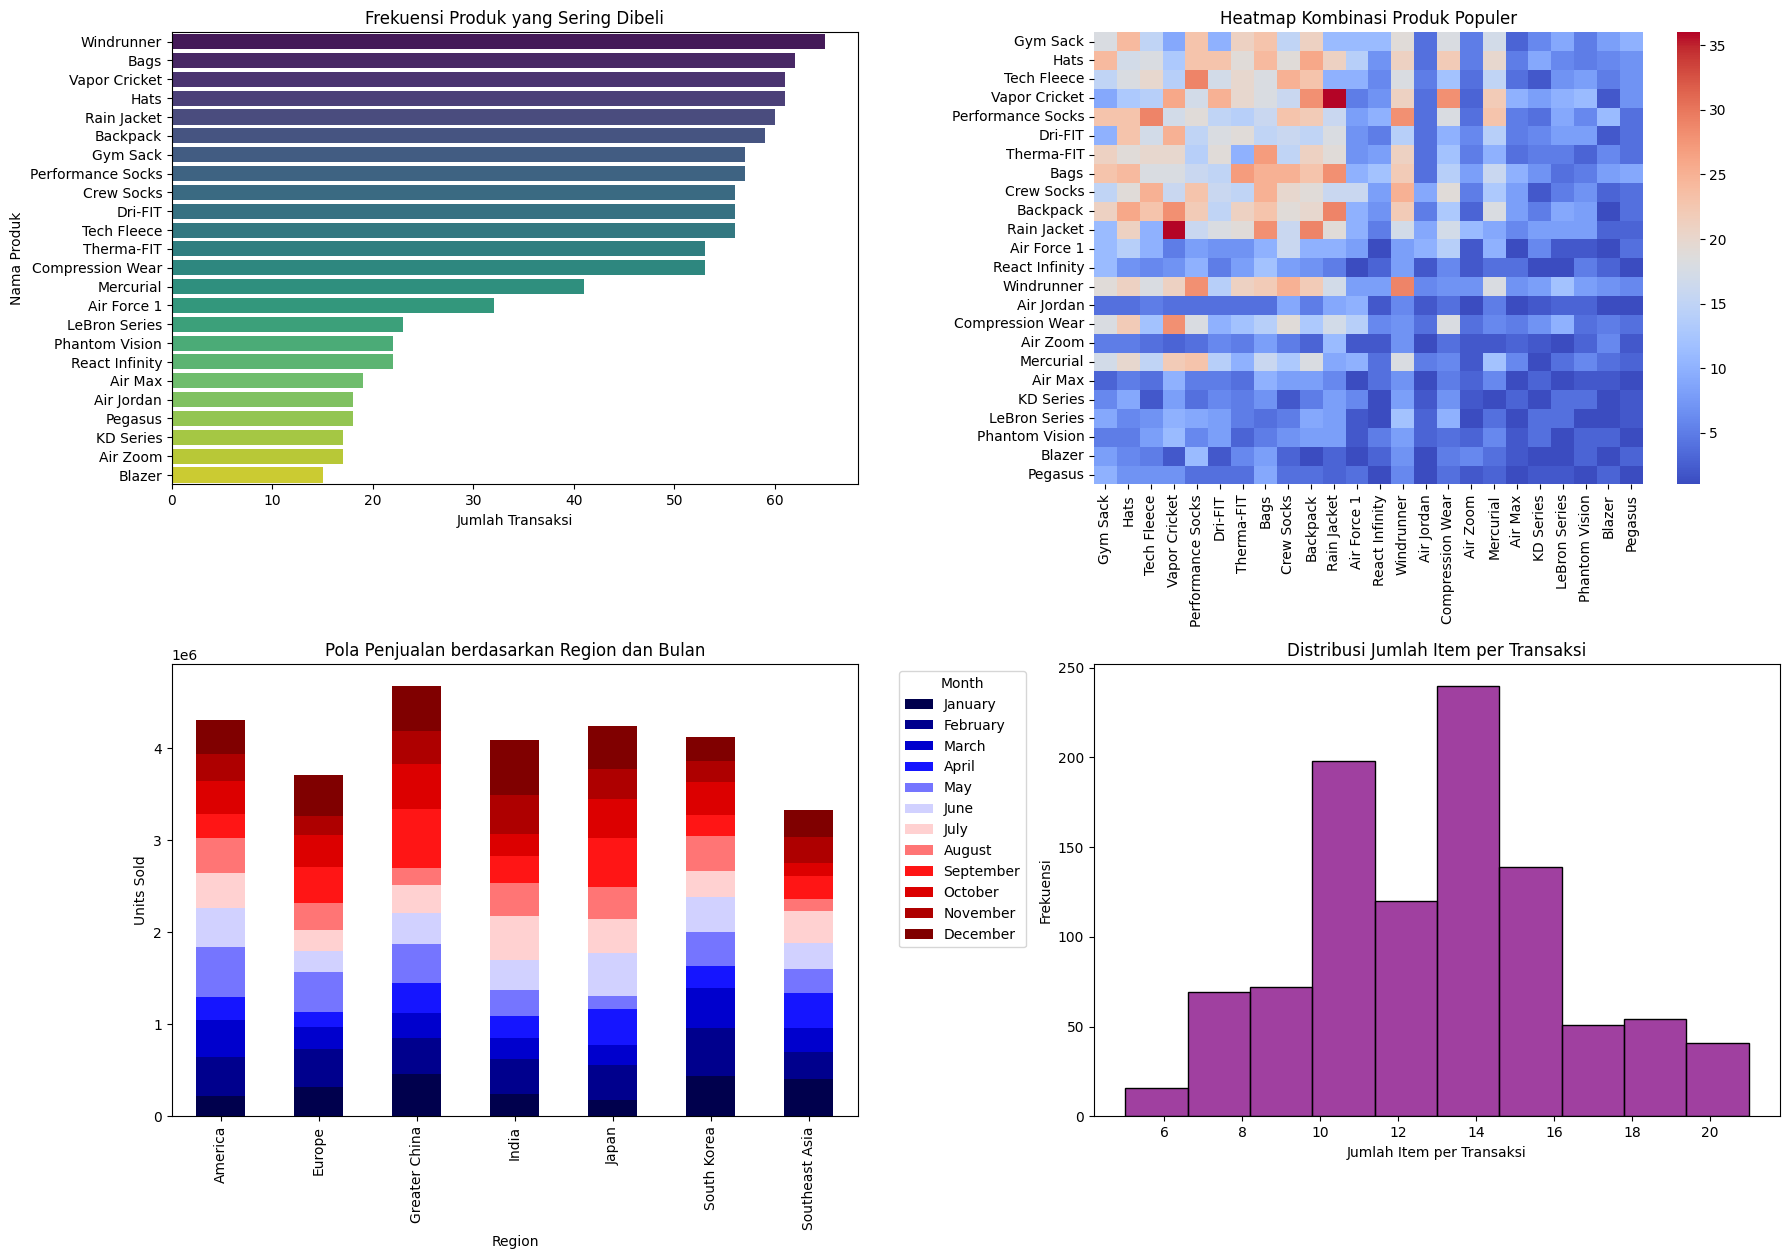

In [6]:
# ===========================
# EDA (Exploratory Data Analysis)
# ===========================

plt.figure(figsize=(18, 24))

# 1. Frekuensi Produk
plt.subplot(4, 2, 1)

sns.barplot(y=product_counts.index, x=product_counts.values, palette='viridis')
plt.title('Frekuensi Produk yang Sering Dibeli')
plt.xlabel('Jumlah Transaksi')
plt.ylabel('Nama Produk')

# 2. Kombinasi Produk Populer (Heatmap)
plt.subplot(4, 2, 2)

# Menghitung kombinasi produk
combination_counts = Counter()
for transaction in transaction_list:
    combination_counts.update(combinations(transaction, 2))

# Membuat DataFrame dari kombinasi produk
comb_df = pd.DataFrame(combination_counts.items(), columns=['Combination', 'Count'])
comb_df = comb_df.sort_values(by='Count', ascending=False).head(10)

# Heatmap dari kombinasi produk
comb_matrix = pd.DataFrame(0, index=unique_items, columns=unique_items)
for (item1, item2), count in combination_counts.items():
    comb_matrix.loc[item1, item2] = count
    comb_matrix.loc[item2, item1] = count
sns.heatmap(comb_matrix, cmap='coolwarm', annot=False)
plt.title('Heatmap Kombinasi Produk Populer')

# 3. Pola Penjualan berdasarkan Region dan Bulan
plt.subplot(4, 2, 3)
sales_by_region_month = sales_by_region_month.reindex(columns=month_order)
sales_by_region_month.plot(kind='bar', stacked=True, colormap='seismic', ax=plt.gca())
plt.title('Pola Penjualan berdasarkan Region dan Bulan')
plt.xlabel('Region')
plt.ylabel('Units Sold')
plt.legend(title='Month', bbox_to_anchor=(1.05, 1))

# 4. Distribusi Jumlah Item per Transaksi
plt.subplot(4, 2, 4)

sns.histplot(data['Items_Per_Transaction'], bins=10, kde=False, color='purple')
plt.title('Distribusi Jumlah Item per Transaksi')
plt.xlabel('Jumlah Item per Transaksi')
plt.ylabel('Frekuensi')

plt.tight_layout()
plt.show()



# SELEKSI FITUR

In [7]:
# ===========================
# Feature Preparation
# ===========================
# Menyiapkan data transaksional dengan mengelompokkan informasi produk berdasarkan region dan bulan
transaction_data = transaction_list.reset_index() #kenapa transaction_list.reset_index?
                                                  #karena transaction_list = data.groupby(['Region', 'Month'])['Product_Line'].apply(list)
                                                  #sudah dibuat di Pre-Processing

# Mengonversi data ke format one-hot encoding untuk FP-Growth
transaction_encoded = pd.DataFrame(
    [[1 if item in products else 0 for item in unique_items] for products in transaction_data['Product_Line']],
    columns=unique_items
)

# MODELING

In [8]:
# ===========================
# Modeling with FP-Growth
# ===========================
min_support = 0.1  # Contoh: itemsets yang muncul setidaknya di 20% transaksi
frequent_itemsets = fpgrowth(transaction_encoded, min_support=min_support, use_colnames=True)

# Menghasilkan aturan asosiasi
rules = association_rules(frequent_itemsets, num_itemsets=len(data), metric='lift', min_threshold=1)

# EVALUASI MODEL

In [9]:
# ===========================
# Evaluation and Results
# ===========================
# Menampilkan itemsets yang sering muncul dan aturan asosiasi teratas
print("Itemsets yang Sering Muncul:")
print(frequent_itemsets.sort_values(by='support', ascending=False).head())

print("\nAturan Asosiasi Teratas:")
print(rules.sort_values(by='lift', ascending=False).head())

# Menyimpan hasil ke CSV
frequent_itemsets.to_csv('frequent_itemsets.csv', index=False)
rules.to_csv('association_rules.csv', index=False)

print("\nHasil disimpan: frequent_itemsets.csv dan association_rules.csv")

Itemsets yang Sering Muncul:
     support         itemsets
8   0.535714           (Hats)
0   0.511905  (Vapor Cricket)
2   0.511905    (Rain Jacket)
15  0.511905     (Windrunner)
1   0.511905     (Therma-FIT)

Aturan Asosiasi Teratas:
                     antecedents                   consequents  \
1052  (Rain Jacket, Air Force 1)        (Crew Socks, Backpack)   
1053     (Backpack, Air Force 1)     (Crew Socks, Rain Jacket)   
1049      (Crew Socks, Backpack)    (Rain Jacket, Air Force 1)   
1048   (Crew Socks, Rain Jacket)       (Backpack, Air Force 1)   
1121   (Bags, Performance Socks)  (Crew Socks, React Infinity)   

      antecedent support  consequent support   support  confidence      lift  \
1052            0.154762            0.226190  0.107143    0.692308  3.060729   
1053            0.154762            0.226190  0.107143    0.692308  3.060729   
1049            0.226190            0.154762  0.107143    0.473684  3.060729   
1048            0.226190            0.154762  0.

In [10]:
# Mengambil aturan dengan lift tertinggi
top_rule = rules.sort_values(by='lift', ascending=False).iloc[0]


top_consequent = list(top_rule['consequents'])

top_antecedents = list(top_rule['antecedents'])

persen = top_rule['confidence'] * 100

print(f"\nJika pelanggan membeli item: {top_antecedents}")
print(f"maka akan memiliki kecenderungan untuk membeli item: {top_consequent} sebesar {persen}%")


Jika pelanggan membeli item: ['Rain Jacket', 'Air Force 1']
maka akan memiliki kecenderungan untuk membeli item: ['Crew Socks', 'Backpack'] sebesar 69.23076923076923%
